In [ ]:
cityscapes_seg_dir = r'/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/cityscapes/gtFine/train/cologne'
coco_seg_dir = r'/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/coco_stuff/val2017'


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


# ASSETS_DIRECTORY = cityscapes_seg_dir

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [147]:
from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
from tqdm import tqdm 
import torch 
import os 

cityscapes_seg_dir = r'/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/cityscapes/gtFine/train/cologne'
coco_seg_dir = r'/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/coco_stuff/val2017'


## CoCo-Stuff size eval

In [148]:
def get_coarse_label(label):
    fine_to_coarse = {0: 9, 1: 11, 2: 11, 3: 11, 4: 11, 5: 11, 6: 11, 7: 11, 8: 11, 9: 8, 10: 8, 11: 8, 12: 8,
                        13: 8, 14: 8, 15: 7, 16: 7, 17: 7, 18: 7, 19: 7, 20: 7, 21: 7, 22: 7, 23: 7, 24: 7,
                        25: 6, 26: 6, 27: 6, 28: 6, 29: 6, 30: 6, 31: 6, 32: 6, 33: 10, 34: 10, 35: 10, 36: 10,
                        37: 10, 38: 10, 39: 10, 40: 10, 41: 10, 42: 10, 43: 5, 44: 5, 45: 5, 46: 5, 47: 5, 48: 5,
                        49: 5, 50: 5, 51: 2, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 2,
                        61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 69: 3, 70: 3, 71: 0, 72: 0,
                        73: 0, 74: 0, 75: 0, 76: 0, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 4, 84: 4,
                        85: 4, 86: 4, 87: 4, 88: 4, 89: 4, 90: 4, 91: 17, 92: 17, 93: 22, 94: 20, 95: 20, 96: 22,
                        97: 15, 98: 25, 99: 16, 100: 13, 101: 12, 102: 12, 103: 17, 104: 17, 105: 23, 106: 15,
                        107: 15, 108: 17, 109: 15, 110: 21, 111: 15, 112: 25, 113: 13, 114: 13, 115: 13, 116: 13,
                        117: 13, 118: 22, 119: 26, 120: 14, 121: 14, 122: 15, 123: 22, 124: 21, 125: 21, 126: 24,
                        127: 20, 128: 22, 129: 15, 130: 17, 131: 16, 132: 15, 133: 22, 134: 24, 135: 21, 136: 17,
                        137: 25, 138: 16, 139: 21, 140: 17, 141: 22, 142: 16, 143: 21, 144: 21, 145: 25, 146: 21,
                        147: 26, 148: 21, 149: 24, 150: 20, 151: 17, 152: 14, 153: 21, 154: 26, 155: 15, 156: 23,
                        157: 20, 158: 21, 159: 24, 160: 15, 161: 24, 162: 22, 163: 25, 164: 15, 165: 20, 166: 17,
                        167: 17, 168: 22, 169: 14, 170: 18, 171: 18, 172: 18, 173: 18, 174: 18, 175: 18, 176: 18,
                        177: 26, 178: 26, 179: 19, 180: 19, 181: 24}

    label[label == 255] = -1  # to be consistent with 10k
    coarse_label = torch.zeros_like(label)
    for fine, coarse in fine_to_coarse.items():
        coarse_label[label == fine] = coarse
    coarse_label[label == -1] = -1
    coarse_label[label == 255] = -1
    return coarse_label

In [149]:
# obj_ids = torch.tensor(list(range(27)))

coco_segs = os.listdir(coco_seg_dir)

# bbox_dict = {i:[] for i in range(27)}
pixel_dict = {i:[] for i in range(27)}
img_counted = 0
img_2_count = 10000
for img_name in tqdm(coco_segs):
    if '.png' in img_name:
        mask = read_image(os.path.join(coco_seg_dir, img_name))
        mask = get_coarse_label(mask)
        obj_ids = torch.unique(mask)
        # obj_ids[obj_ids == 255] = -1
        # masks = mask == obj_ids[:, None, None]
        # print(obj_ids, masks.shape)
        # boxes = masks_to_boxes(masks)
        # print(f'boxes {boxes.shape}')
        # torch.count
        for i in range(len(obj_ids)):
            if obj_ids[i].item() != 255:
                pixel_dict[obj_ids[i].item()].append(torch.count_nonzero(mask == obj_ids[i]))
        img_counted += 1
    if img_counted > img_2_count:
        break 

# size_dict = {i:[] for i in range(27)}
# for i in tqdm(range(27)):
#     total = 0
#     total_size = 0
#     for bbox in bbox_dict[i]:
#         size = max(bbox[3] - bbox[1], bbox[2] - bbox[0])
#         size_dict[i].append(size.item())


100%|██████████| 10000/10000 [01:32<00:00, 107.79it/s] 


In [182]:
import math
size_dict = {i:[] for i in range(27)}
# area = 1024 * 2048
for i in range(27):
    # size_dict[i] = [math.sqrt(j.item()) for j in pixel_dict[i]]
    size_dict[i] = [math.log(j.item(), math.e) for j in pixel_dict[i]]

In [150]:
cityscapes_names = ['road', 'sidewalk', 'parking', 'rail track', 'building',
'wall', 'fence', 'guard rail', 'bridge', 'tunnel',
'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation',
'terrain', 'sky', 'person', 'rider', 'car',
'truck', 'bus', 'caravan', 'trailer', 'train',
'motorcycle', 'bicycle']
cocostuff_names = [
            "electronic", "appliance", "food", "furniture", "indoor",
            "kitchen", "accessory", "animal", "outdoor", "person",
            "sports", "vehicle", "ceiling", "floor", "food",
            "furniture", "rawmaterial", "textile", "wall", "window",
            "building", "ground", "plant", "sky", "solid",
            "structural", "water"]

/home/zhulifu/unsup_seg/stego/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


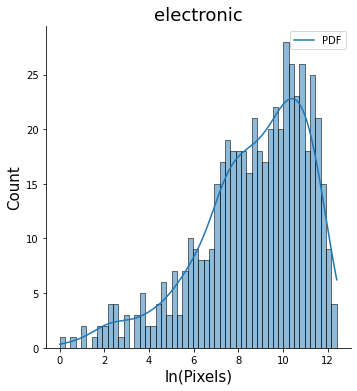

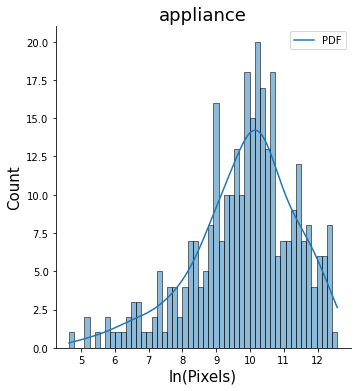

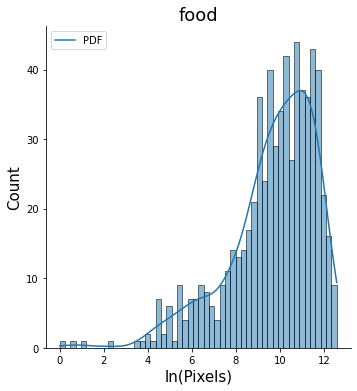

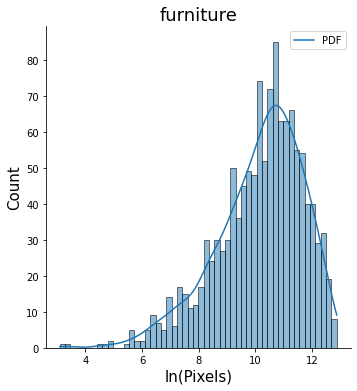

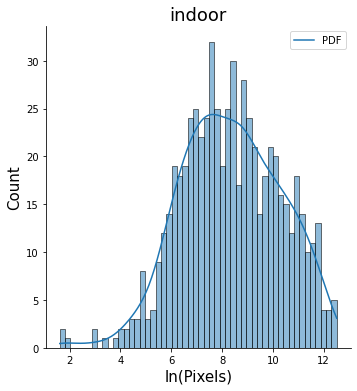

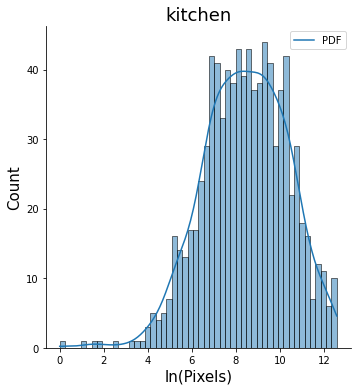

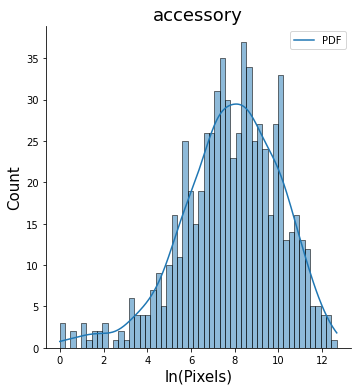

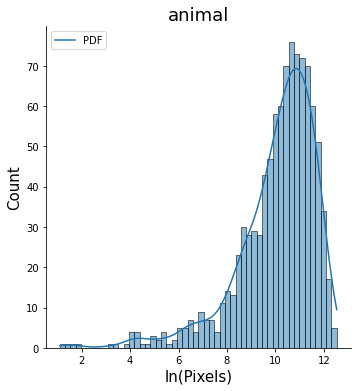

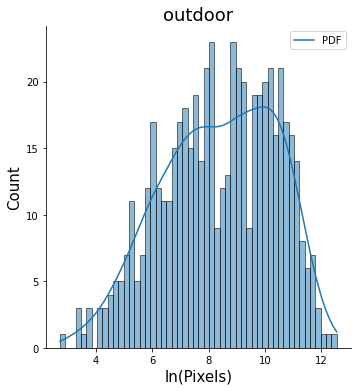

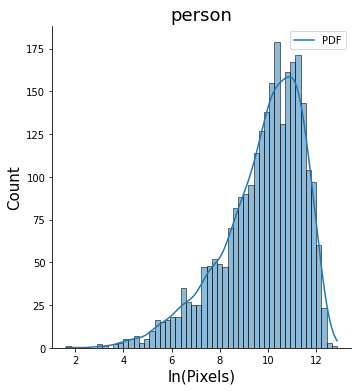

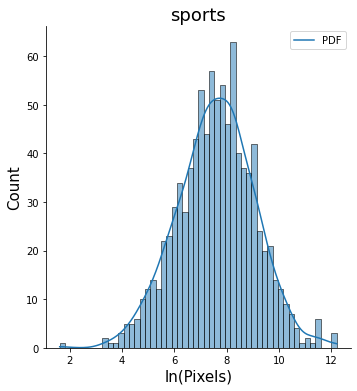

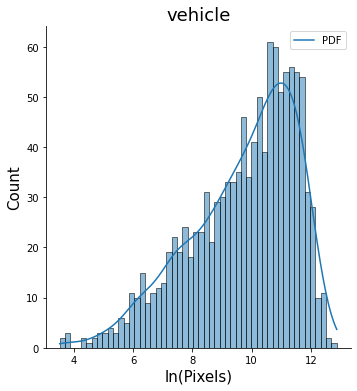

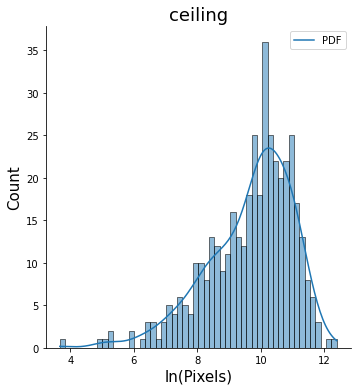

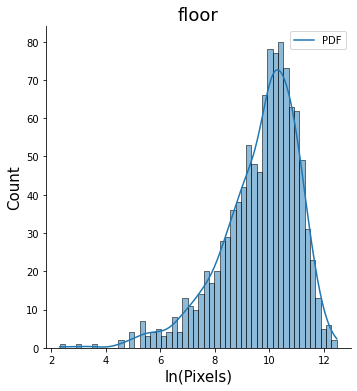

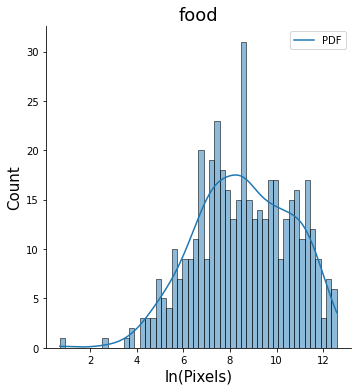

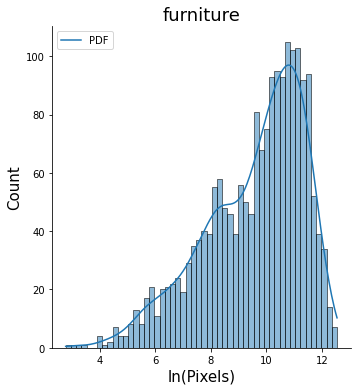

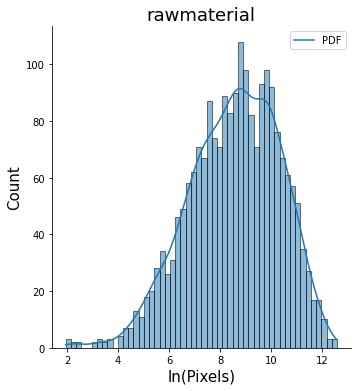

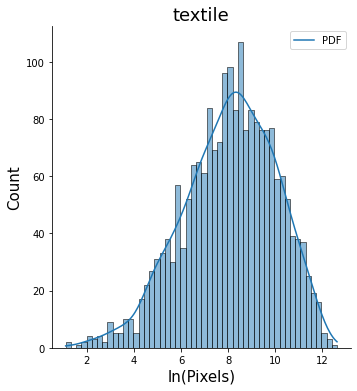

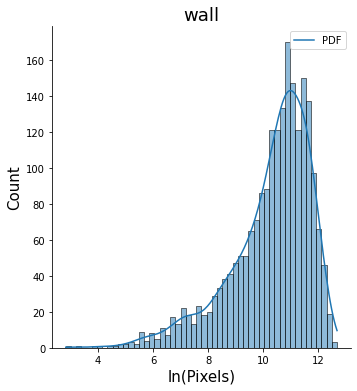

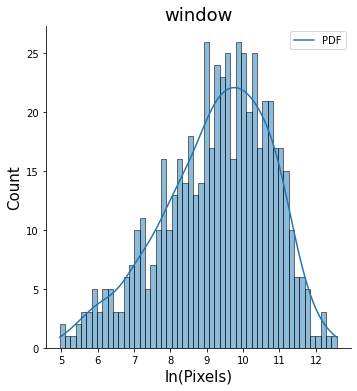

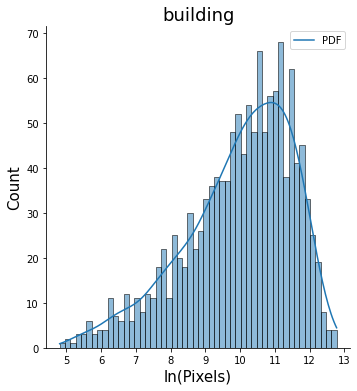

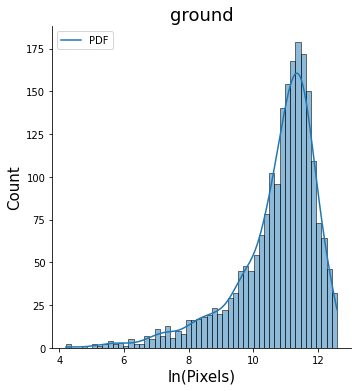

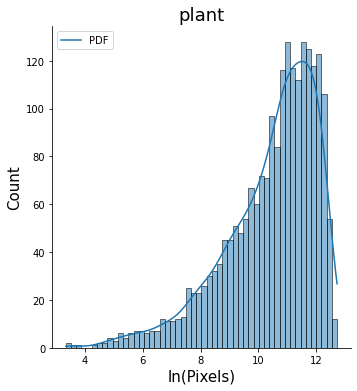

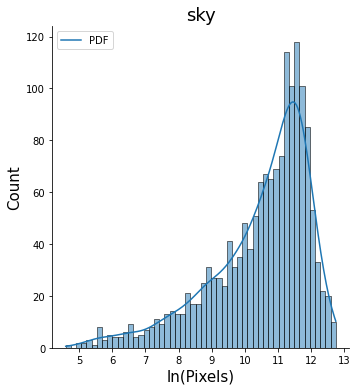

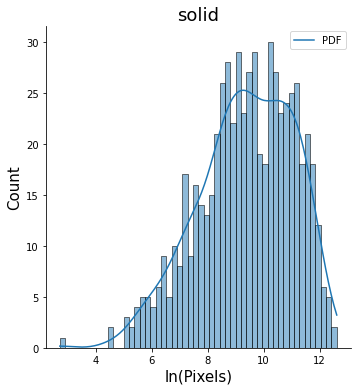

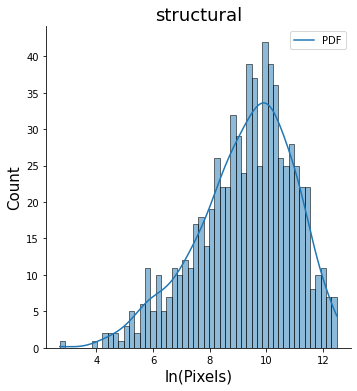

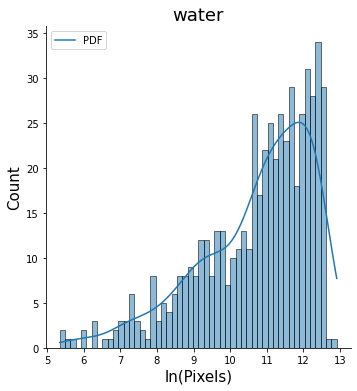

In [183]:
import seaborn as sns
for i in range(27):
    fig = sns.displot(size_dict[i], bins=52, kde=True);
    plt.title(f'{cocostuff_names[i]}', fontsize=18)
    plt.legend(['PDF'])
    plt.xlabel('ln(Pixels)', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    fig.savefig(f'/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/size_analysis/cocostuff/{cocostuff_names[i]}', dpi=400)

In [ ]:
import seaborn as sns
sns.displot(size_dict[0], bins=52, kde=True);
plt.legend(['PDF'])
plt.xlabel('ln(Pixels)', fontsize=20)
plt.ylabel('Count', fontsize=20)

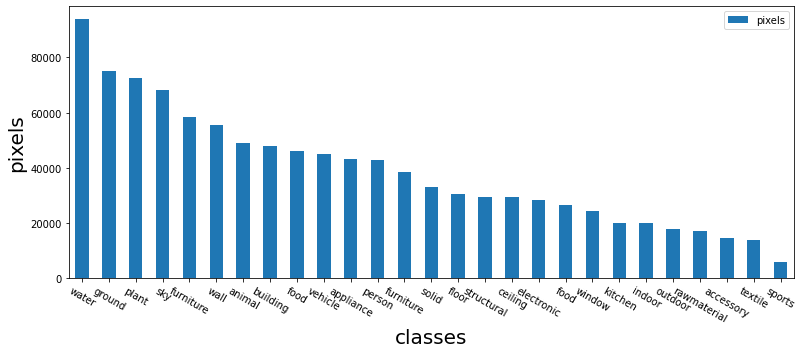

In [152]:
import pandas as pd 
fig = plt.figure(figsize=(13, 5))
ax= fig.add_subplot()
nd = {
    'classes' : [
            "electronic", "appliance", "food", "furniture", "indoor",
            "kitchen", "accessory", "animal", "outdoor", "person",
            "sports", "vehicle", "ceiling", "floor", "food",
            "furniture", "rawmaterial", "textile", "wall", "window",
            "building", "ground", "plant", "sky", "solid",
            "structural", "water"]
}
means = [torch.mean(torch.tensor(pixel_dict[i], dtype=torch.float64)).item() for i in range(27)]
nd['pixels'] = means
f = pd.DataFrame(nd)
# plt.tight_layout()
fnew = f.sort_values(by='pixels', ascending=False)
fnew.plot.bar(x='classes', rot=-30,ax=ax)
ax.set_xlabel('classes', fontsize=20)
ax.set_ylabel('pixels', fontsize=20)
plt.savefig('/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/size_analysis/cocostuff/pixel_count.png', dpi=400)

In [ ]:
import scipy.stats as st
import numpy as np

x = size_dict[5]
plt.hist(x, density=True, bins=82, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability")
plt.xlabel("Data")
plt.title("Histogram");

## Cityscapes 分析

In [142]:
# obj_ids = torch.tensor(list(range(27)))

def get_coarse_label(label):
    fine_to_coarse = {0:-1, 1:-1, 2:-1, 3:-1, 4:-1, 5:-1, 6:-1, 7:0, 8:1, 9:2, 10:3, 11:4, 12:5, 13:6,
             14:7, 15:8, 16:9, 17:10, 18:11, 19:12, 20:13, 21:14, 22:15, 23:16, 24:17, 25:18, 26:19,
             27:20, 28:21, 29:22, 30:23, 31:24, 32:25, 33:26, -1:-1}

    label[label == 255] = -1  # to be consistent with 10k
    coarse_label = torch.zeros_like(label)
    for fine, coarse in fine_to_coarse.items():
        coarse_label[label == fine] = coarse
    coarse_label[label == -1] = -1
    return coarse_label



# bbox_dict = {i:[] for i in range(27)}
pixel_dict = {i:[] for i in range(27)}
img_counted = 0
img_2_count = 10000
cityscapes_seg_dir = r'/home/zhulifu/unsup_seg/STEGO-master/seg_dataset/cityscapes/gtFine/train'
for city in os.listdir(cityscapes_seg_dir):
    city_segs = os.listdir(cityscapes_seg_dir + '/' + city)
    for img_name in tqdm(city_segs):
        if 'gtFine_labelIds.png' in img_name:
            mask = read_image(os.path.join(cityscapes_seg_dir, city, img_name))
            # print('for img name ', img_name)
            mask = get_coarse_label(mask)
            obj_ids = torch.unique(mask)
            # print(obj_ids)
            # obj_ids[obj_ids == 255] = -1
            # masks = mask == obj_ids[:, None, None]
            # print(obj_ids, masks.shape)
            # boxes = masks_to_boxes(masks)
            # print(f'boxes {boxes.shape}')
            # torch.count
            for i in range(len(obj_ids)):
                if obj_ids[i].item() != 255:
                    pixel_dict[obj_ids[i].item()].append(torch.count_nonzero(mask == obj_ids[i]))
            img_counted += 1
        if img_counted > img_2_count:
            break 

# size_dict = {i:[] for i in range(27)}
# for i in tqdm(range(27)):
#     total = 0
#     total_size = 0
#     for bbox in bbox_dict[i]:
#         size = max(bbox[3] - bbox[1], bbox[2] - bbox[0])
#         size_dict[i].append(size.item())


100%|██████████| 376/376 [00:05<00:00, 72.85it/s] 


In [143]:
import math
size_dict = {i:[] for i in range(27)}
area = 1024 * 2048
for i in range(27):
    # size_dict[i] = [math.sqrt(j.item()) for j in pixel_dict[i]]
    size_dict[i] = [math.log(j.item(), math.e) for j in pixel_dict[i]]

/home/zhulifu/unsup_seg/stego/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


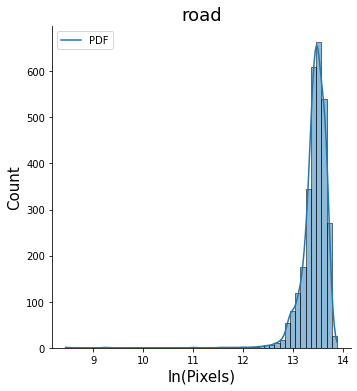

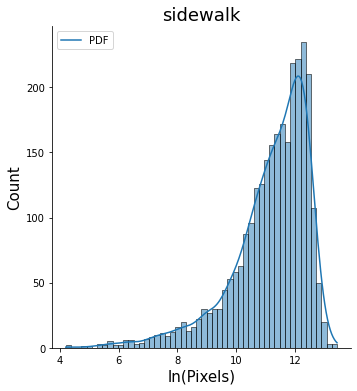

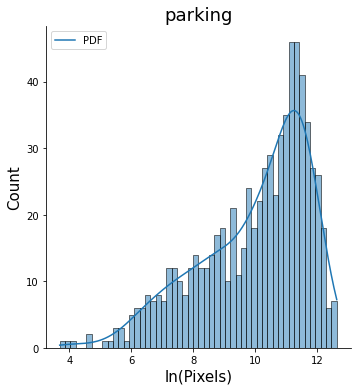

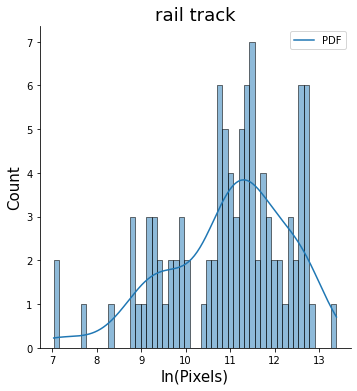

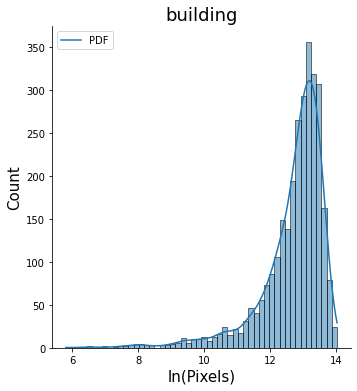

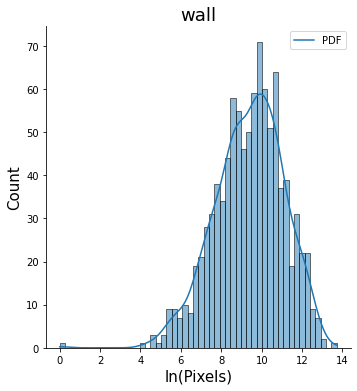

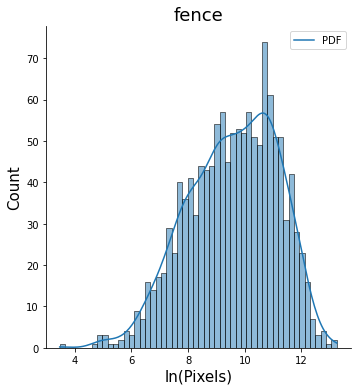

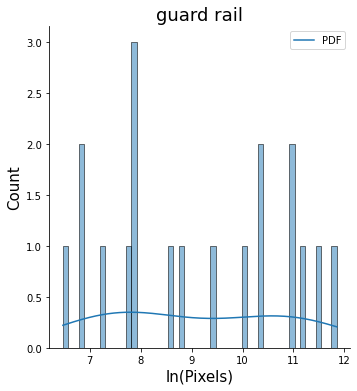

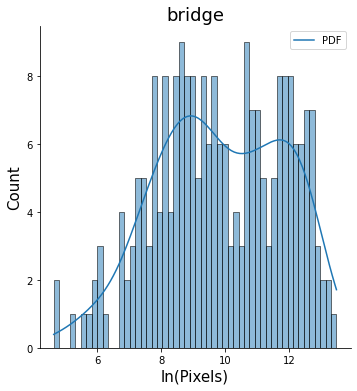

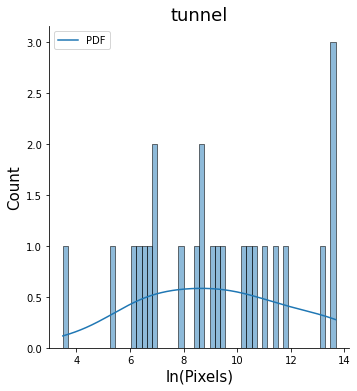

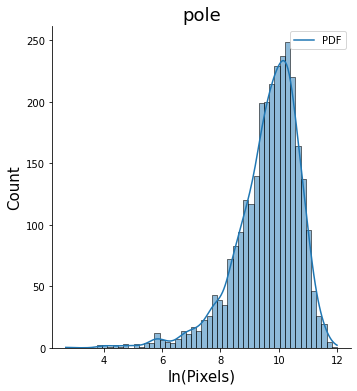

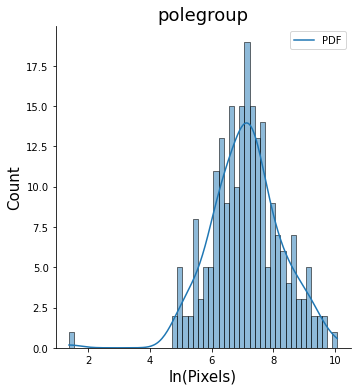

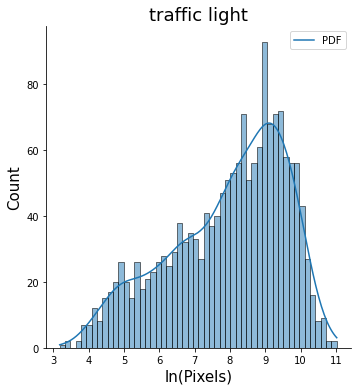

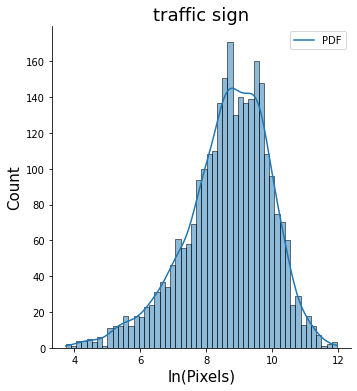

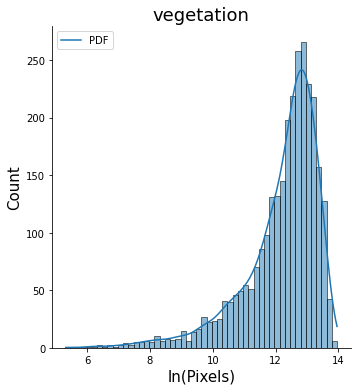

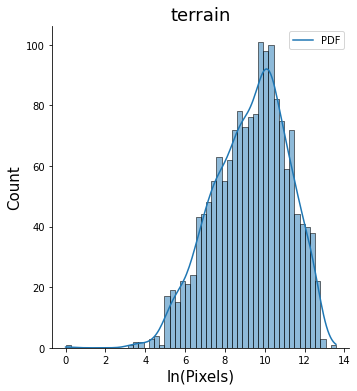

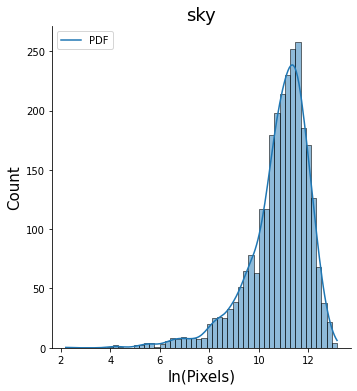

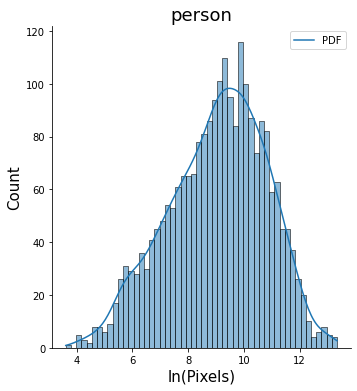

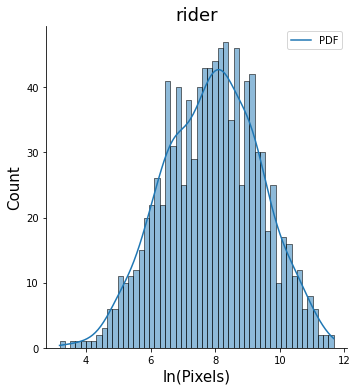

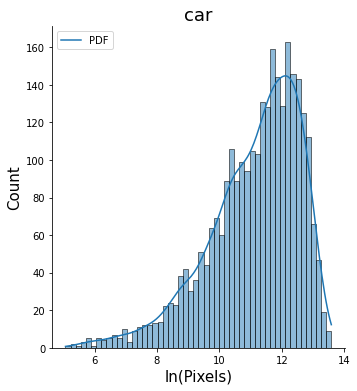

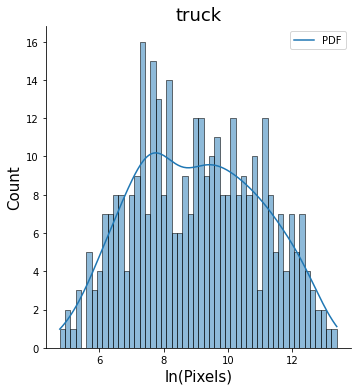

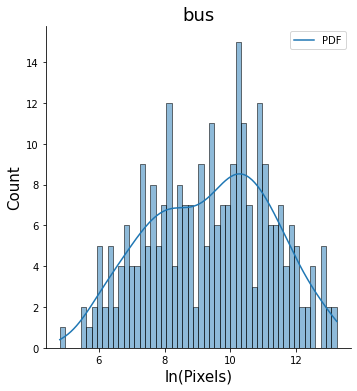

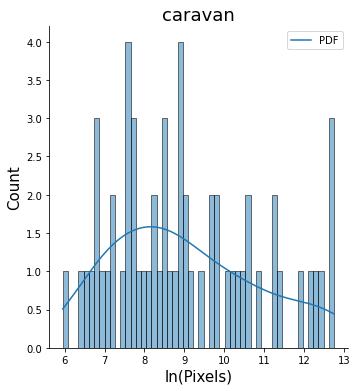

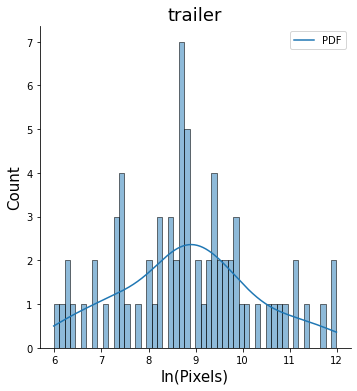

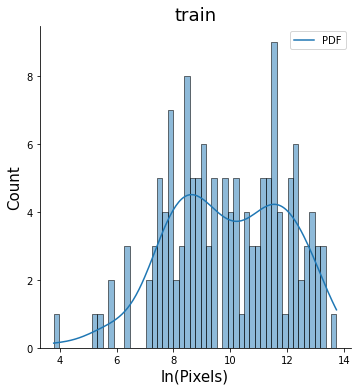

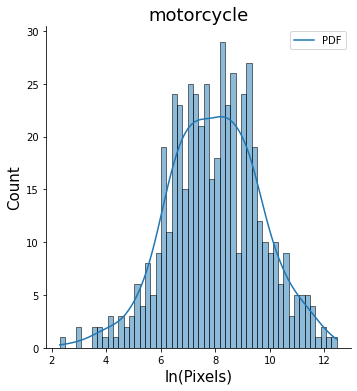

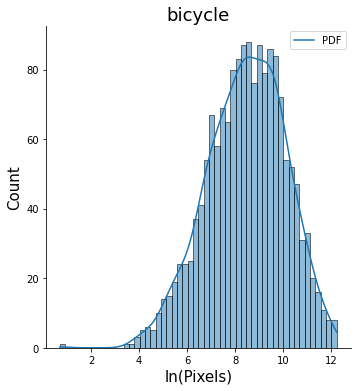

In [181]:
import seaborn as sns
for i in range(27):
    # plt.figure(figsize=(6,8))
    # sns.set_context({'figure.figsize':[8, 10]})
    # plt.margins(10,10)
    
    fig = sns.displot(size_dict[i], bins=52, kde=True);
    plt.legend(['PDF'])
    plt.title(f'{cityscapes_names[i]}', fontsize=18)
    plt.xlabel('ln(Pixels)', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    # plt.subplots_adjust(left=0.15, bottom=0.12, right=1.2, top=1.2,hspace=0.1,wspace=0.1)
    # plot_margin = 0.25
    # plt.margins(x=0, y=0.2)
    fig.savefig(f'/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/size_analysis/cityscapes/{cityscapes_names[i]}', dpi=300)
    # plt.savefig(f'{cityscapes_names[i]}', dpi=300)

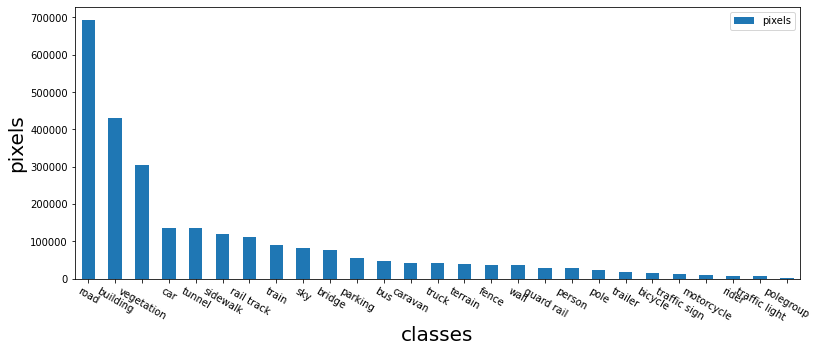

In [146]:
import pandas as pd 
fig = plt.figure(figsize=(13, 5))
ax= fig.add_subplot()
nd = {
    'classes' : [
            'road', 'sidewalk', 'parking', 'rail track', 'building',
            'wall', 'fence', 'guard rail', 'bridge', 'tunnel',
            'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation',
            'terrain', 'sky', 'person', 'rider', 'car',
            'truck', 'bus', 'caravan', 'trailer', 'train',
            'motorcycle', 'bicycle'
            # , 'unknown'
            ]
}
means = [torch.mean(torch.tensor(pixel_dict[i], dtype=torch.float64)).item() for i in range(27)]
nd['pixels'] = means
f = pd.DataFrame(nd)
# plt.tight_layout()
fnew = f.sort_values(by='pixels', ascending=False)
fnew.plot.bar(x='classes', rot=-30,ax=ax)
ax.set_xlabel('classes', fontsize=20)
ax.set_ylabel('pixels', fontsize=20)
plt.savefig('/home/zhulifu/unsup_seg/trials_unsupervised_segmentation/size_analysis/cityscapes/pixel_count.png', dpi=400)